Install and Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.impute import KNNImputer
import random
from datetime import datetime, timedelta
import datetime as dt
import warnings
from wordcloud import WordCloud
import shap
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from scipy.stats import f_oneway, kruskal, levene, shapiro

import optuna
from optuna.samplers import TPESampler


Import Data

In [2]:
df1 = pd.read_csv('ems_train_test.csv')
df2 = pd.read_csv('ems_out_of_time_testing.csv')

In [3]:
df_miss = pd.DataFrame(df1.isnull().sum())
df_miss.reset_index(inplace=True)
df_miss.columns=['Var','MissingCount']
df_miss.sort_values(by='MissingCount',ascending=False)
df_miss.head(10)

,Var,MissingCount
0,vin,0
1,year_week,0
2,chassis_type,0
3,obd_emissions_phase_regulation,0
4,axle_arrangement,0
5,model_name,0
6,aerodyn_device_roof,0
7,aerodyn_device_roof_height,0
8,aux_horn,0
9,aerodyn_device_cabside,0


Split Features and Target

In [4]:
# Define features and target
X = df1.drop('liters_per_driven_100km', axis=1)
y = df1['liters_per_driven_100km']

2. Data Preprocessing: Handle missing values, perform any necessary data cleaning, and convert
categorical variables into numerical representations (e.g., one-hot encoding or label encoding).

In [ ]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns # Get the column names instead of the entire DataFrame

# Preprocessing for numerical data
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', StandardScaler())                 # Scale numerical features
])

# Preprocessing of categorical data
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent value
    ('encoder', OneHotEncoder(handle_unknown='ignore'))   # Convert categorical variables to one-hot encoding
])

# Combine both pipelines into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ],
    remainder='passthrough'  # This will pass through any columns not specified in the transformers
)

# variable transformation
X_processed = preprocessor.fit_transform(X)

3. EDA to check the distribution of the actual numeric variables

In [6]:
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
description = X[numerical_cols].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
description_transposed = description.transpose()
description_transposed

,count,mean,std,min,10%,25%,50%,75%,90%,95%,99%,max
vin,71520.0,-8.300294e+15,4.371472e+18,-9.222970e+18,-6.002680e+18,-3.275922e+18,3.850900e+15,3.289498e+18,5.945168e+18,7.242724e+18,8.729983e+18,9.221430e+18
engine_capacity,71520.0,1.209238e+01,6.552690e-01,1.100000e+01,1.100000e+01,1.200000e+01,1.200000e+01,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01
meters_top_gear,71520.0,1.656487e+06,9.019035e+05,2.160000e+02,4.973028e+05,9.732162e+05,1.597636e+06,2.256610e+06,2.873232e+06,3.246249e+06,3.937463e+06,5.980053e+06
seconds_idle,71520.0,2.051993e+04,1.539890e+04,9.300000e+01,3.315900e+03,8.305000e+03,1.737550e+04,2.961800e+04,4.209310e+04,5.005840e+04,6.610606e+04,1.249250e+05
seconds_pto,71520.0,8.116957e+03,6.121712e+03,0.000000e+00,1.260000e+03,3.210000e+03,6.887000e+03,1.172200e+04,1.676700e+04,1.981505e+04,2.607105e+04,4.353000e+04
meters_cruise,71520.0,1.109590e+06,7.934872e+05,3.400000e+01,1.932177e+05,4.765250e+05,9.687560e+05,1.591386e+06,2.216244e+06,2.611630e+06,3.390862e+06,5.872369e+06
meters_engine_out_green,71520.0,8.303503e+04,6.253391e+04,4.000000e+00,1.338600e+04,3.343000e+04,7.009150e+04,1.196298e+05,1.707122e+05,2.030321e+05,2.678529e+05,5.124350e+05
seconds_engine_out_green,71477.0,4.073488e+03,3.072312e+03,0.000000e+00,6.606000e+02,1.629000e+03,3.449000e+03,5.869000e+03,8.370000e+03,9.979200e+03,1.319072e+04,2.439900e+04
meters_driving,71520.0,2.267348e+06,9.833072e+05,1.506890e+05,9.869150e+05,1.559641e+06,2.237080e+06,2.927544e+06,3.564976e+06,3.942417e+06,4.662950e+06,6.761423e+06
seconds_driving,71520.0,1.176053e+05,4.664103e+04,7.167000e+03,5.681990e+04,8.493275e+04,1.167615e+05,1.490662e+05,1.788522e+05,1.959714e+05,2.294172e+05,3.124560e+05


4. Dimensionality Reduction using Principal Component Analysis

Determine - optimal number of components using scree plot

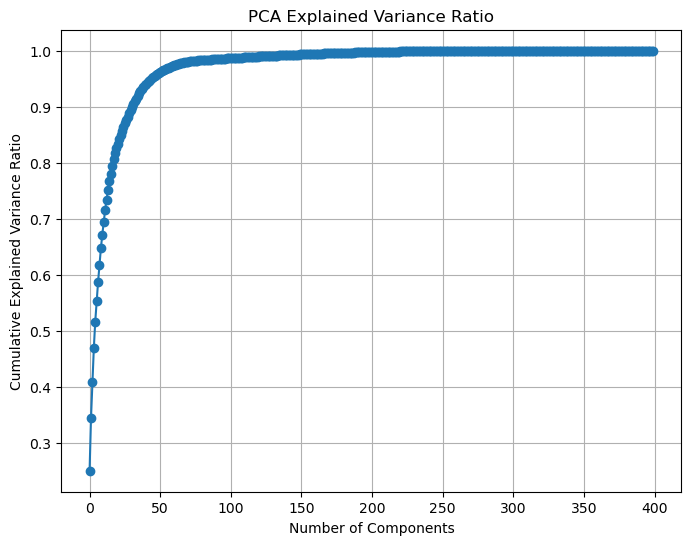

In [7]:
from sklearn.decomposition import PCA
# Perform PCA
pca = PCA()
pca.fit(X_processed.toarray())

# Plot explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.grid(True)
plt.show()

About 48 clusters explain 90% of variance

In [8]:
# Transform the data
pca = PCA(n_components=48)
pca.fit(X_processed.toarray())
X_reduced = pca.transform(X_processed.toarray())

# Convert the reduced data to a DataFrame for easier handling
X_reduced_df = pd.DataFrame(X_reduced, columns=[f'PC{i+1}' for i in range(48)])

In [10]:
X_reduced_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48
0,-4.784476,-2.237596,2.084750,0.360980,0.444940,0.356729,0.873806,-0.955232,2.930221,-0.959345,...,-0.065765,-0.941470,0.121774,-0.571278,0.304824,0.035203,0.009708,-0.086753,-0.406773,-0.110039
1,1.996420,-0.578577,1.463983,-5.408951,-0.605106,-2.254143,2.392646,0.903982,-1.204418,0.092425,...,-0.987843,0.019210,0.073510,0.019494,-0.663517,0.889645,0.130668,-0.208663,-0.092187,0.466735
2,-4.031973,-1.787856,-2.904593,2.283725,-2.770377,0.645089,-1.091171,-0.276747,0.947746,0.188604,...,0.375693,0.088582,-0.240827,0.220466,-0.571432,0.263821,-0.265984,0.120661,-0.337329,-0.002766
3,5.198049,-2.008403,-0.864637,-0.685750,-0.608024,0.069268,-0.022948,-0.665576,-2.620606,1.194231,...,0.204255,0.213898,-0.449584,0.365370,0.468660,-0.489370,1.152140,0.674736,-0.499925,-0.369463
4,-4.779077,-0.129806,-1.723080,1.565008,-0.515789,2.681291,0.146641,0.435170,-0.032559,0.393109,...,-0.028268,0.065563,-0.251943,-0.210997,0.043268,0.237055,0.273419,-0.464659,0.151223,0.065361


5. Split Data into Train and Test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=43) #Considering actual variables as Independant Variables

6. Feature Selection - RFECV- Recursive Feature Elimination Using Cross Validation with Random Forest as Base Estimator and having SHAP plots for variable importance

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

# Initialize RandomForestRegressor with parallel processing
rf = RandomForestRegressor(n_estimators=5, random_state=42, n_jobs=-1)#Increse of n estimators would make modelm robust but time consuming to fit

# Create RFECV object with cross-validation
rfecv = RFECV(estimator=rf, step=1, cv=5, scoring='r2', n_jobs=-1)

# Fit RFECV (this will now use parallel processing within RandomForest)
rfecv.fit(X_train, y_train)

# Get the selected features mask (True for selected, False for not selected)
selected_features = rfecv.support_

# Print the number of selected features
print(f"Optimal number of features: {rfecv.n_features_}")

# Plot number of features VS cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (R²)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


Refit the model with Selected features

In [15]:

# Train RandomForestRegressor on selected features
X_train_rfe = X_train.loc[:, selected_features]
X_test_rfe = X_test.loc[:, selected_features]

# Refit the model with only the selected features
rf.fit(X_train_rfe, y_train)


SHAP plots for variable importance

In [ ]:

# SHAP Analysis
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train_rfe)

# SHAP summary plot for feature importance
shap.summary_plot(shap_values, X_train_rfe, feature_names=[f'Feature_{i}' for i, selected in enumerate(selected_features) if selected])


7. Model Selection - Considering Linear Regression, Gradient Boost and Random Forest

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def model_selection(X_train, X_test, y_train, y_test):
    # Initialize models
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=10, random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=10, random_state=42)
    }

    results = {}

    for name, model in models.items():
        # Fit model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate R² score and RMSE
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        # Store results
        results[name] = {"R² Score": r2, "RMSE": rmse}

        # Print model performance
        print(f"{name}:\n\tR² Score: {r2:.4f}\n\tRMSE: {rmse:.4f}\n")

    return results


In [12]:
#Use the selected Features for model selection

results = model_selection(X_train, X_test, y_train, y_test)

Linear Regression:
	R² Score: 0.8535
	RMSE: 1.9909

Random Forest:
	R² Score: 0.7958
	RMSE: 2.3506

Gradient Boosting:
	R² Score: 0.5674
	RMSE: 3.4216



Linear Regression has Highest R Square and lesser RMSE. Hence considering that for next steps

9. Model Optimization - Hyper parameter tune. Using Elastic Net to reduce over fit since it is a combination of Lasso and Ridge Regression

In [13]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Step 1: Hyperparameter Tuning for ElasticNet
# Define the parameter grid
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],  # Strength of regularization
    'l1_ratio': [0.1, 0.5, 0.7, 1.0]  # Balance between Lasso and Ridge (0 -> Ridge, 1 -> Lasso)
}

# Initialize the ElasticNet model
elastic_net = ElasticNet(max_iter=1000)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=5, scoring='r2')

# Fit GridSearchCV to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best parameters
best_alpha = grid_search.best_params_['alpha']
best_l1_ratio = grid_search.best_params_['l1_ratio']
print(f"Best Alpha: {best_alpha}")
print(f"Best L1 Ratio: {best_l1_ratio}")

Best Alpha: 0.01
Best L1 Ratio: 0.1


Final Model fit using the best alpha and l1 ratios

In [15]:
final_model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=1000)
final_model.fit(X_train, y_train)

ElasticNet(alpha=0.01, l1_ratio=0.1)

Evaluate the Final Model on Test Data

In [16]:
y_test_pred = final_model.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Test Data R² Score: {r2_test:.4f}")
print(f"Test Data RMSE: {rmse_test:.4f}")

Test Data R² Score: 0.8458
Test Data RMSE: 2.0430


10. Model validation on Out of time data

In [18]:
df2.columns.tolist()

['vin',
 'year_week',
 'chassis_type',
 'obd_emissions_phase_regulation',
 'axle_arrangement',
 'model_name',
 'aerodyn_device_roof',
 'aerodyn_device_roof_height',
 'aux_horn',
 'aerodyn_device_cabside',
 'bumper_spoiler',
 'sunvisor_exterior',
 'aerodyn_device_chassis',
 'chassis_height',
 'transmission',
 'clutchable_air_compressor',
 'power_steering_pump',
 'idle_shutdown_enabled',
 'cruise_control',
 'transmission_software_package',
 'pre_view_topography',
 'retarder',
 'transmission_retarder_cooler',
 'compressor_capacity',
 'alternator_capacity',
 'tire_pressure_monitoring',
 'engine_capacity',
 'rear_axle_type',
 'meters_top_gear',
 'seconds_idle',
 'seconds_pto',
 'meters_cruise',
 'meters_engine_out_green',
 'seconds_engine_out_green',
 'meters_driving',
 'seconds_driving',
 'seconds_overload',
 'seconds_cruise',
 'seconds_economy',
 'seconds_top_gear',
 'seconds_mode_auto',
 'seconds_mode_power',
 'seconds_mode_manual',
 'n_stops',
 'n_brakes',
 'seconds_total',
 'meters_tot

In [17]:
X2 = df2.drop('liters_per_driven_100km', axis=1)
y_out_of_time = df2['liters_per_driven_100km']

KeyError: "['liters_per_driven_100km'] not found in axis"

X_out_of_time = preprocessor.fit_transform(X2)

In [ ]:
y_out_of_time_pred = final_model.predict(X_out_of_time)
r2_out_of_time = r2_score(y_out_of_time, y_out_of_time_pred)
rmse_out_of_time = np.sqrt(mean_squared_error(y_out_of_time, y_out_of_time_pred))

print(f"Out-of-Time Data R² Score: {r2_out_of_time:.4f}")
print(f"Out-of-Time Data RMSE: {rmse_out_of_time:.4f}")

Target variable not found in the out of time testing dataset